# Load e imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
250/60

4.166666666666667

In [3]:
df = pd.read_csv('data_balanced.csv', encoding='utf-8')

In [4]:
df['result'].value_counts()

result
1    20707
0    20707
Name: count, dtype: int64

# Avaliando modelo por liga

## Preprocessamento

In [5]:
# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
        ],
        remainder='passthrough'  # Mantém as características categóricas sem transformação
    )
    return preprocessor.fit(X)

## Treinamento

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score

# Lista das ligas únicas no conjunto de dados
leagues = df['league'].unique()

# Dicionário para armazenar histórico de treinamento e avaliação para cada liga
league_histories = {}

# Loop por cada liga para criar, treinar e avaliar um modelo separado
t = len(leagues)
for league in leagues:
    print(f"Treinando modelo para a liga: {league} ({t} ligas restantes)")
    t -= 1
    
    # Filtrando o conjunto de dados para apenas a liga atual
    league_data = df[df['league'] == league]
    
    # Preparando os dados de entrada e saída
    X = league_data.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
    y = league_data['result']

    preprocessor = create_preprocessor(X)
    X_transformed = preprocessor.transform(X)

    weight_calss_0 = (len(y) - y.sum()) / len(y)
    weight_calss_1 = y.sum() / len(y)

    class_weight = {0: weight_calss_0/2, 1: weight_calss_1*2}

    
    model_randomf = RandomForestClassifier(
                                            n_estimators=100, 
                                            random_state=42, 
                                            min_samples_split=5, 
                                            min_samples_leaf=2, 
                                            # class_weight=class_weight
                                        )

    # Validação cruzada
    cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='roc_auc')
    print(f"Média AUC para {league}: {cv_scores.mean()}")

    # acuracia
    cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='accuracy')
    print(f"Média Acurácia para {league}: {cv_scores.mean()}")

    # Treinando e avaliando o modelo
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model_randomf.fit(X_train, y_train)
    train_auc = roc_auc_score(y_train, model_randomf.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, model_randomf.predict_proba(X_test)[:, 1])

    feature_importance = model_randomf.feature_importances_

    # Armazenando a avaliação em um dicionário
    league_histories[league] = {
        'cv_auc_mean': cv_scores.mean(),
        'train_auc': train_auc,
        'test_auc': test_auc,
        'feature_importance': feature_importance
    }

    # Predicting the values
    y_pred = model_randomf.predict(X_test)
    
    # classification report
    print(classification_report(y_test, y_pred))
    print()

Treinando modelo para a liga: South America - Copa Libertadores (33 ligas restantes)
Média AUC para South America - Copa Libertadores: 0.3345012849584278
Média Acurácia para South America - Copa Libertadores: 0.3950483779169039
              precision    recall  f1-score   support

           0       0.43      0.30      0.35       114
           1       0.54      0.67      0.60       138

    accuracy                           0.50       252
   macro avg       0.48      0.49      0.48       252
weighted avg       0.49      0.50      0.49       252


Treinando modelo para a liga: Asia - AFC Champions League (32 ligas restantes)
Média AUC para Asia - AFC Champions League: 0.29548134756657485
Média Acurácia para Asia - AFC Champions League: 0.3777662517289073
              precision    recall  f1-score   support

           0       0.53      0.39      0.45       116
           1       0.54      0.68      0.60       125

    accuracy                           0.54       241
   macro avg   

## Avaliando importancia das features de cada liga

In [7]:
dataframe_league = pd.DataFrame.from_dict(league_histories, orient='index')
dataframe_league

,cv_auc_mean,train_auc,test_auc,feature_importance
South America - Copa Libertadores,0.395048,0.995974,0.506674,"[0.07603861496399844, 0.0260672541322032, 0.01..."
Asia - AFC Champions League,0.377766,0.997210,0.545034,"[0.077732142897986, 0.024520823833615077, 0.01..."
Brazil - Paulista A1,0.398332,0.996963,0.484629,"[0.07648177331020206, 0.022385387990980492, 0...."
South America - Copa Sudamericana,0.365755,0.996255,0.445248,"[0.0722679308715469, 0.020938328871615335, 0.0..."
Japan - J-League,0.387705,0.998500,0.508547,"[0.08042434166574158, 0.021621573244778737, 0...."
USA - Major League Soccer,0.393941,0.997298,0.477504,"[0.0818668677788092, 0.023557716530193416, 0.0..."
Mexico - Liga MX,0.381147,0.997453,0.477023,"[0.08187688982031553, 0.021049308651827983, 0...."
Scotland - Premiership,0.389706,0.997928,0.423238,"[0.08072814026781536, 0.02610816883199806, 0.0..."
Brazil - Serie A,0.395364,0.998932,0.475269,"[0.07951231401903344, 0.022434545285241515, 0...."
France - Ligue 1,0.390927,0.997685,0.549263,"[0.08441170778120537, 0.025728005673924352, 0...."


In [8]:
# Calculando a média da importância de cada característica em todas as ligas
mean_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist()).mean().tolist()

# Convertendo a lista de importâncias das características em um DataFrame para facilitar a análise
df_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist())

# Calculando a variância da importância de cada característica em todas as ligas
feature_variances = df_feature_importances.var()

# Criando um DataFrame resumo para conter os dados de variância e correlação
summary_df = pd.DataFrame({
    'Mean Importance': mean_feature_importances,
    'Variance': feature_variances,
})

# Exibindo o DataFrame resumo ordenado por variância para ver quais características têm mais variabilidade entre as ligas
summary_df.sort_values('Variance', ascending=False, inplace=True)
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Feature'}, inplace=True)

feature_names = df.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1).columns
# feature_names = df.drop(['result', 'league'], axis=1).columns

# Mapeando os números para os nomes das características
summary_df['Feature Name'] = summary_df['Feature'].apply(lambda x: feature_names[x])

summary_df.sort_values('Mean Importance', ascending=False)


,Feature,Mean Importance,Variance,Feature Name
11,0,0.078675,0.000014,minute
6,24,0.075248,0.000017,possessiontime_home
8,23,0.074016,0.000016,possessiontime_away
2,22,0.062420,0.000020,tackles_away
9,21,0.062081,0.000015,tackles_home
5,17,0.056649,0.000017,fouls_home
0,18,0.056187,0.000028,fouls_away
12,3,0.051452,0.000013,shotsHome
16,4,0.047370,0.000009,shotsAway
19,11,0.044479,0.000009,shotsOffgoal_home


- Importância das Características: A tabela fornece um valor de importância média para cada característica, que indica quanto essa característica contribui para a capacidade do modelo de fazer previsões. Quanto maior o valor, mais importante é a característica.

- Variância da Importância: A variância pode nos dizer quão consistente é a importância de uma característica entre os diferentes modelos de liga. Uma variância baixa significa que a característica tem aproximadamente a mesma importância em todas as ligas, enquanto uma variância alta sugere que a importância da característica varia significativamente entre as diferentes ligas.

- Diferenças entre as Ligas: Se algumas características têm uma alta variância na importância, isso pode indicar que as ligas têm dinâmicas diferentes que afetam os resultados dos jogos. Por exemplo, uma característica pode ser muito importante em uma liga, mas menos importante em outra.

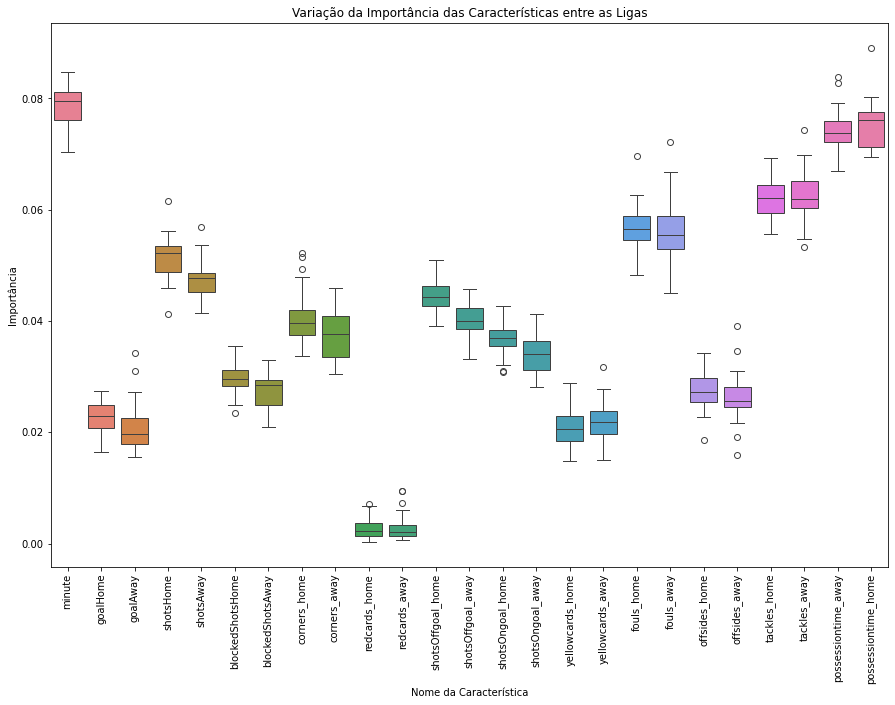

In [9]:
# Conversão do que ta no dataframe para lista
def convert_to_list(ndarray):
    # Verifica se o ndarray não é vazio e converte para lista
    return ndarray.tolist() if ndarray.size else []

importance_lists = dataframe_league['feature_importance'].apply(convert_to_list)

# Criando um DataFrame para armazenar os valores de importância para todas as ligas
feature_importance_df = pd.DataFrame(importance_lists.tolist())

# Calculando estatísticas descritivas para cada característica em todas as ligas
feature_importance_stats = feature_importance_df.describe()

# feature_names = summary_df['Feature Name'].tolist()

# Criar o gráfico de boxplot
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=feature_importance_df)
ax.set_title('Variação da Importância das Características entre as Ligas')
ax.set_xlabel('Nome da Característica')
ax.set_ylabel('Importância')
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90)
plt.show()


- Variação na Importância: Características com boxplots mais largos indicam uma maior variação na sua importância entre as ligas. Isso sugere que o impacto dessas características é mais específico para cada liga. Por outro lado, características com boxplots mais estreitos mostram uma consistência maior, indicando que a importância dessas características é mais uniforme entre as ligas.
Outliers:

- Alguns boxplots têm pontos outliers, que representam ligas onde a importância da característica é notavelmente diferente do padrão observado na maioria das outras ligas. Esses outliers podem indicar casos específicos onde uma característica é particularmente mais ou menos relevante.

- Modelos Personalizados para Ligas: As características com maior variação (boxplots mais largos e/ou com outliers) são fortes candidatas a justificar a criação de modelos separados para cada liga. Isso permitiria que os modelos levassem em conta as peculiaridades de cada liga, resultando em previsões mais precisas.

- Características com menor variação podem ser tratadas de forma mais consistente entre os modelos para diferentes ligas.

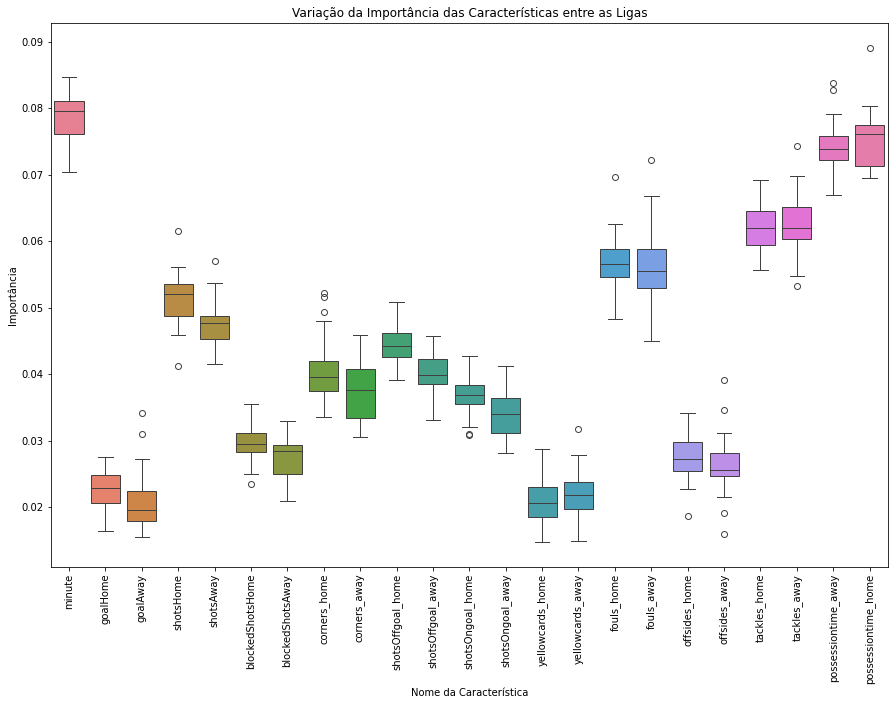

In [10]:
low_importance_features_indices = summary_df[summary_df['Mean Importance'] <= 0.014532]['Feature'].tolist()

feature_importance_df_filtered = feature_importance_df.drop(columns=low_importance_features_indices, axis=1)

feature_names_filtered = [feature_names[i] for i in range(len(feature_names)) if i not in low_importance_features_indices]

# Criar o gráfico de boxplot
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=feature_importance_df_filtered)
ax.set_title('Variação da Importância das Características entre as Ligas')
ax.set_xlabel('Nome da Característica')
ax.set_ylabel('Importância')
plt.xticks(ticks=np.arange(len(feature_names_filtered)), labels=feature_names_filtered, rotation=90)
plt.show()


# Engenharia de recursos

Em 'A League-Wide Evaluation of Factors Influencing Match Activity Profile in Elite Australian Football', Esmaeili, Clifton e Aughey (2020) destacam a complexidade e a multifatorialidade do desempenho em jogos de futebol de elite. As medidas de desempenho utilizadas para o sistema de análise de partidas 'Champdas Master System' foram divididas em 
- Desempenho relacionado ao ataque
- Desempenho relacionado com passes
- Desempenho relacionado com Defesa

Nos dados, as estatisticas,
- de ataque são: shotsOngoal, shotsOffGoal, corners
- relacionada a passes: possessiontime
- relacionado a defesa: tackles, blockedShots

Anotações: Essas variáveis do artigo foram utilizadas para interpretar o impacto com os proprios dados do jogo. O trabalho presente avalia essas características como variáveis preditoras

In [11]:
df = pd.read_csv('data_trated.csv', encoding='utf-8')
# Desempenho Relacionado ao Ataque
df['shotsOnGoalEfficiency'] = (df['shotsOngoal_home'] + df['shotsOngoal_away']) / (df['shotsHome'] + df['shotsAway'] + 1) # A eficiência do ataque em termos de chutes que realmente vão em direção ao gol.
df['attackPressure'] = (df['shotsHome'] + df['shotsAway'] + df['corners_home'] + df['corners_away']) / df['minute'] # Uma medida de quão ofensivas as equipes estão ao longo do jogo.
df['shotAccuracy_home'] = df['shotsOngoal_home'] / (df['shotsHome'] + 1) # Proporção de chutes no gol em relação ao total de chutes.
df['shotAccuracy_away'] = df['shotsOngoal_away'] / (df['shotsAway'] + 1)

# Desempenho relacionado com chutes 
df['shotsMinute_Home'] = df['minute'].where(df['shotsHome'].diff().fillna(0) > 0)
df['shotsMinute_Away'] = df['minute'].where(df['shotsAway'].diff().fillna(0) > 0)

# Desempenho Relacionado com Passes
df['possessionControl'] = abs(df['possessiontime_home'] - df['possessiontime_away']) # Diferença absoluta do tempo de posse entre as equipes, indicando qual equipe dominou a posse de bola.
# df['passRisk'] = (df['offsides_home'] + df['offsides_away']) / (df['possessiontime_home'] + df['possessiontime_away']) # Indicativo de quão arriscados são os passes, resultando em impedimentos.
df['passRiskHome'] = df['offsides_home'] / (df['possessiontime_home']+ 0.01)
df['passRiskAway'] = df['offsides_away'] / (df['possessiontime_away']+ 0.01)

# Desempenho Relacionado com Defesa
df['TotalCards_home'] = df['redcards_home'] + df['yellowcards_home']
df['TotalCards_away'] = df['redcards_away'] + df['yellowcards_away']

df['defensiveDiscipline'] = (1 - (df['redcards_home'] + df['yellowcards_home'] + df['fouls_home'] + 
                                   df['redcards_away'] + df['yellowcards_away'] + df['fouls_away']) / df['minute']) # Uma medida de quão disciplinadas as equipes estão em termos de cartões e faltas.

df['defensiveEfficacy'] = (df['blockedShotsHome'] + df['blockedShotsAway']) / (df['shotsOnGoalEfficiency'] + 1) # Avalia a habilidade da defesa de bloquear chutes eficientes.
df['defensiveAggression'] = (df['tackles_home'] + df['tackles_away']) / df['minute'] # Indicativo de quão agressiva a equipe é na defesa ao longo do jogo.

# Desempenho Relacionado a chutes
df['shotsMinute_Home'] = df['minute'].where(df['shotsHome'].diff().fillna(0) > 0)
df['shotsMinute_Away'] = df['minute'].where(df['shotsAway'].diff().fillna(0) > 0)
df['timeSinceLastEventShots_Home'] = df['minute'] - df.groupby(df['shotsMinute_Home'].notnull().cumsum())['minute'].transform('first')
df['timeSinceLastEventShots_Away'] = df['minute'] - df.groupby(df['shotsMinute_Away'].notnull().cumsum())['minute'].transform('first')

#  Desempenho relacionado com escanteios
df['cornersMinute_Home'] = df['minute'].where(df['corners_home'].diff().fillna(0) > 0)
df['cornersMinute_Away'] = df['minute'].where(df['corners_away'].diff().fillna(0) > 0)
df['timeSinceLastEventCorners_Home'] = df['minute'] - df.groupby(df['cornersMinute_Home'].notnull().cumsum())['minute'].transform('first')
df['timeSinceLastEventCorners_Away'] = df['minute'] - df.groupby(df['cornersMinute_Away'].notnull().cumsum())['minute'].transform('first')

# Desempenho relacionado com passes
df['passesMinute_Home'] = df['minute'].where(df['possessiontime_home'].diff().fillna(0) > 0)
df['passesMinute_Away'] = df['minute'].where(df['possessiontime_away'].diff().fillna(0) > 0)
df['timeSinceLastEventPasses_Home'] = df['minute'] - df.groupby(df['passesMinute_Home'].notnull().cumsum())['minute'].transform('first')
df['timeSinceLastEventPasses_Away'] = df['minute'] - df.groupby(df['passesMinute_Away'].notnull().cumsum())['minute'].transform('first')

# Desempenho Relacionado com Gols
df['goalMinute_Home'] = df['minute'].where(df['goalHome'].diff().fillna(0) > 0)
df['goalMinute_Away'] = df['minute'].where(df['goalAway'].diff().fillna(0) > 0)
df['timeSinceLastEvent_Home'] = df['minute'] - df.groupby(df['goalMinute_Home'].notnull().cumsum())['minute'].transform('first')
df['timeSinceLastEvent_Away'] = df['minute'] - df.groupby(df['goalMinute_Away'].notnull().cumsum())['minute'].transform('first')

# Desempenho relacionado com faltas
df['foulsMinute_Home'] = df['minute'].where(df['fouls_home'].diff().fillna(0) > 0)
df['foulsMinute_Away'] = df['minute'].where(df['fouls_away'].diff().fillna(0) > 0)
df['timeSinceLastEventFouls_Home'] = df['minute'] - df.groupby(df['foulsMinute_Home'].notnull().cumsum())['minute'].transform('first')
df['timeSinceLastEventFouls_Away'] = df['minute'] - df.groupby(df['foulsMinute_Away'].notnull().cumsum())['minute'].transform('first')

# Desempenho relacionado com cartões
df['TotalCardsMinute_Home'] = df['minute'].where(df['TotalCards_home'].diff().fillna(0) > 0)
df['TotalCardsMinute_Away'] = df['minute'].where(df['TotalCards_away'].diff().fillna(0) > 0)
df['timeSinceLastEventTotalCards_Home'] = df['minute'] - df.groupby(df['TotalCardsMinute_Home'].notnull().cumsum())['minute'].transform('first')
df['timeSinceLastEventTotalCards_Away'] = df['minute'] - df.groupby(df['TotalCardsMinute_Away'].notnull().cumsum())['minute'].transform('first')

event_columns = ['shotsHome', 'shotsAway', 'possessiontime_home', 'possessiontime_away', 'blockedShotsHome', 'blockedShotsAway', 'corners_home', 'corners_away', 'redcards_home', 'redcards_away',
       'shotsOffgoal_home', 'shotsOffgoal_away', 'shotsOngoal_home',
       'shotsOngoal_away', 'yellowcards_home', 'yellowcards_away',
       'fouls_home', 'fouls_away', 'offsides_home', 'offsides_away',
       'tackles_home', 'tackles_away']

def calculate_event_change(data, event_column, lookback=10):
    """
    Calcula a mudança no evento especificado para cada linha, olhando para os 
    10 registros anteriores. A diferença entre os valores máximo e mínimo nesse
    intervalo é calculada.
    """
    # Nome da nova coluna
    new_column = f'total_change_{event_column}'

    # Calculando o valor máximo e mínimo em uma janela deslizante
    rolling_max = data[event_column].rolling(window=lookback, min_periods=1).max()
    rolling_min = data[event_column].rolling(window=lookback, min_periods=1).min()

    # Calculando a diferença e atribuindo à nova coluna
    data[new_column] = rolling_max - rolling_min

    return data

for event_column in event_columns:
    df = calculate_event_change(df, event_column)


In [12]:
df.drop(columns=['goalMinute_Home', 'goalMinute_Away', 'shotsMinute_Home', 'shotsMinute_Away', 'passesMinute_Home', 'passesMinute_Away', 'foulsMinute_Home', 'foulsMinute_Away', 'TotalCardsMinute_Home', 'TotalCardsMinute_Away', 'cornersMinute_Home', 'cornersMinute_Away'], inplace=True)

In [13]:
df.columns

Index(['minute', 'homeTeam', 'awayTeam', 'goalHome', 'goalAway', 'shotsHome',
       'shotsAway', 'blockedShotsHome', 'blockedShotsAway', 'league',
       'corners_home', 'corners_away', 'redcards_home', 'redcards_away',
       'shotsOffgoal_home', 'shotsOffgoal_away', 'shotsOngoal_home',
       'shotsOngoal_away', 'yellowcards_home', 'yellowcards_away',
       'fouls_home', 'fouls_away', 'offsides_home', 'offsides_away',
       'tackles_home', 'tackles_away', 'result', 'match_id',
       'possessiontime_away', 'possessiontime_home', 'shotsOnGoalEfficiency',
       'attackPressure', 'shotAccuracy_home', 'shotAccuracy_away',
       'possessionControl', 'passRiskHome', 'passRiskAway', 'TotalCards_home',
       'TotalCards_away', 'defensiveDiscipline', 'defensiveEfficacy',
       'defensiveAggression', 'timeSinceLastEventShots_Home',
       'timeSinceLastEventShots_Away', 'timeSinceLastEventCorners_Home',
       'timeSinceLastEventCorners_Away', 'timeSinceLastEventPasses_Home',
       'ti

In [14]:
# Expandido a função para calcular as estatísticas baseada no histórico dos ultimos 10 jogos de cada time
# Função para calcular as estatísticas dinâmicas
def calculate_expanded_stats(df, team_column, goal_column):
    # Ordenando os dados
    df_sorted = df.sort_values(by=['match_id', 'minute'])

    # Calculando os gols em cada tempo
    df_sorted['first_half_goals'] = df_sorted[goal_column].where(df_sorted['minute'] <= 45, 0)
    df_sorted['second_half_goals'] = df_sorted[goal_column].where(df_sorted['minute'] > 45, 0)

    # diminuindo gol do segundo tempo pelo gol do primeiro tempo
    df_sorted['second_half_goals'] = df_sorted['second_half_goals'] - df_sorted['first_half_goals']

    # Agrupando por time e match_id e calculando os gols cumulativos
    df_grouped = df_sorted.groupby([team_column, 'match_id']).agg(
        cum_first_half_goals=pd.NamedAgg(column='first_half_goals', aggfunc='max'),
        cum_second_half_goals=pd.NamedAgg(column='second_half_goals', aggfunc='max'),
        cum_full_game_goals=pd.NamedAgg(column=goal_column, aggfunc='max')
    ).reset_index()

    # Calculando as estatísticas rolantes para os últimos 10 jogos, excluindo o jogo atual
    stats_columns = {
        '05ht': lambda x: (x >= 1).mean(),
        '15ht': lambda x: (x >= 2).mean(),
        '25ht': lambda x: (x >= 3).mean(),
        '05ft': lambda x: (x >= 1).mean(),
        '15ft': lambda x: (x >= 2).mean(),
        '25ft': lambda x: (x >= 3).mean(),
        '05': lambda x: (x >= 1).mean(),
        '15': lambda x: (x >= 2).mean(),
        '25': lambda x: (x >= 3).mean()
    }

    for key, func in stats_columns.items():
        if 'ht' in key:
            df_grouped[f'{key}'] = df_grouped.groupby(team_column)['cum_first_half_goals'].transform(
                lambda x: x.rolling(window=10, min_periods=1).apply(lambda y: func(y.head(10)), raw=False)
            )
        elif 'ft' in key:
            df_grouped[f'{key}'] = df_grouped.groupby(team_column)['cum_second_half_goals'].transform(
                lambda x: x.rolling(window=10, min_periods=1).apply(lambda y: func(y.head(10)), raw=False)
            )
        else:
            df_grouped[f'{key}'] = df_grouped.groupby(team_column)['cum_full_game_goals'].transform(
                lambda x: x.rolling(window=10, min_periods=1).apply(lambda y: func(y.head(10)), raw=False)
            )

    # Mantendo apenas as colunas relevantes
    cols_to_keep = [team_column, 'match_id'] + [f'{key}' for key in stats_columns.keys()]
    df_stats = df_grouped[cols_to_keep]

    return df_stats

# Calculando as estatísticas expandidas para os times de casa e visitantes
home_expanded_stats = calculate_expanded_stats(df, 'homeTeam', 'goalHome')
away_expanded_stats = calculate_expanded_stats(df, 'awayTeam', 'goalAway')

# Unindo as novas estatísticas de volta ao DataFrame original
df_with_expanded_stats = df.merge(home_expanded_stats, how='left', on=['homeTeam', 'match_id'])
df_with_expanded_stats = df_with_expanded_stats.merge(away_expanded_stats, how='left', left_on=['awayTeam', 'match_id'], right_on=['awayTeam', 'match_id'])

# Verificando as alterações
df_with_expanded_stats.head()


,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,blockedShotsHome,blockedShotsAway,league,...,25_x,05ht_y,15ht_y,25ht_y,05ft_y,15ft_y,25ft_y,05_y,15_y,25_y
0,1,Valencia CF,Real Madrid CF,0.0,0.0,0.0,0.0,0.0,0.0,Spain - Super Cup,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2,Valencia CF,Real Madrid CF,0.0,0.0,0.0,0.0,0.0,0.0,Spain - Super Cup,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3,Valencia CF,Real Madrid CF,0.0,0.0,0.0,1.0,0.0,0.0,Spain - Super Cup,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3,4,Valencia CF,Real Madrid CF,0.0,0.0,0.0,1.0,0.0,0.0,Spain - Super Cup,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
4,5,Valencia CF,Real Madrid CF,0.0,0.0,0.0,2.0,0.0,0.0,Spain - Super Cup,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [15]:
# Removendo os sufixos _x e _y e renomeando as colunas corretamente
df_with_expanded_stats.columns = [col.replace('_x', '_home').replace('_y', '_away') for col in df_with_expanded_stats.columns]


In [16]:
df_with_expanded_stats.columns

Index(['minute', 'homeTeam', 'awayTeam', 'goalHome', 'goalAway', 'shotsHome',
       'shotsAway', 'blockedShotsHome', 'blockedShotsAway', 'league',
       'corners_home', 'corners_away', 'redcards_home', 'redcards_away',
       'shotsOffgoal_home', 'shotsOffgoal_away', 'shotsOngoal_home',
       'shotsOngoal_away', 'yellowcards_home', 'yellowcards_away',
       'fouls_home', 'fouls_away', 'offsides_home', 'offsides_away',
       'tackles_home', 'tackles_away', 'result', 'match_id',
       'possessiontime_away', 'possessiontime_home', 'shotsOnGoalEfficiency',
       'attackPressure', 'shotAccuracy_home', 'shotAccuracy_away',
       'possessionControl', 'passRiskHome', 'passRiskAway', 'TotalCards_home',
       'TotalCards_away', 'defensiveDiscipline', 'defensiveEfficacy',
       'defensiveAggression', 'timeSinceLastEventShots_Home',
       'timeSinceLastEventShots_Away', 'timeSinceLastEventCorners_Home',
       'timeSinceLastEventCorners_Away', 'timeSinceLastEventPasses_Home',
       'ti

In [17]:
df_with_expanded_stats[df_with_expanded_stats['homeTeam'] == 'SC Corinthians Paulista'][['minute', 'homeTeam', 'awayTeam', 'goalHome', 'goalAway', '05ht_home', '15ht_home', '25ht_home',
       '05ft_home', '15ft_home', '25ft_home', '05_home', '15_home', '25_home',
       '05ht_away', '15ht_away', '25ht_away', '05ft_away', '15ft_away',
       '25ft_away', '05_away', '15_away', '25_away']].head(1000).to_csv('data_teste.csv', index=False, encoding='utf-8')

In [18]:
df_with_expanded_stats

,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,blockedShotsHome,blockedShotsAway,league,...,25_home,05ht_away,15ht_away,25ht_away,05ft_away,15ft_away,25ft_away,05_away,15_away,25_away
0,1,Valencia CF,Real Madrid CF,0.0,0.0,0.0,0.0,0.0,0.0,Spain - Super Cup,...,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0
1,2,Valencia CF,Real Madrid CF,0.0,0.0,0.0,0.0,0.0,0.0,Spain - Super Cup,...,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0
2,3,Valencia CF,Real Madrid CF,0.0,0.0,0.0,1.0,0.0,0.0,Spain - Super Cup,...,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0
3,4,Valencia CF,Real Madrid CF,0.0,0.0,0.0,1.0,0.0,0.0,Spain - Super Cup,...,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0
4,5,Valencia CF,Real Madrid CF,0.0,0.0,0.0,2.0,0.0,0.0,Spain - Super Cup,...,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772964,86,Saint Mirren FC,Kilmarnock FC,0.0,1.0,9.0,10.0,2.0,3.0,Scotland - Premiership,...,0.1,0.333333,0.111111,0.0,0.666667,0.222222,0.0,0.666667,0.222222,0.0
772965,87,Saint Mirren FC,Kilmarnock FC,0.0,1.0,9.0,10.0,2.0,3.0,Scotland - Premiership,...,0.1,0.333333,0.111111,0.0,0.666667,0.222222,0.0,0.666667,0.222222,0.0
772966,88,Saint Mirren FC,Kilmarnock FC,0.0,1.0,9.0,10.0,2.0,3.0,Scotland - Premiership,...,0.1,0.333333,0.111111,0.0,0.666667,0.222222,0.0,0.666667,0.222222,0.0
772967,89,Saint Mirren FC,Kilmarnock FC,0.0,1.0,9.0,12.0,2.0,4.0,Scotland - Premiership,...,0.1,0.333333,0.111111,0.0,0.666667,0.222222,0.0,0.666667,0.222222,0.0


In [19]:
# df_with_expanded_stats.head(1000).to_csv('data_teste.csv', index=False, encoding='utf-8')

In [20]:
df = df_with_expanded_stats.copy()

Contando partidas por time...
Total de partidas: 8591

Filtrando dados de ligas...
Dados filtrados:

league
USA - Major League Soccer            48794
England - Championship               39417
Brazil - Serie A                     38245
Argentina - Superliga                37168
England - League One                 34739
England - League Two                 34020
Spain - La Liga 2                    29610
Japan - J-League                     29146
Mexico - Liga MX                     25289
Spain - La Liga                      23040
Italy - Serie B                      22229
England - Premier League             22140
Europe - Champions League            21780
South America - Copa Libertadores    21060
Europe - Europa League               20606
France - Ligue 1                     20519
Italy - Serie A                      20430
Saudi Arabia - Pro League            20340
Asia - AFC Champions League          19440
Europe - UEFA Nations League         17550
Portugal - Liga Portugal        

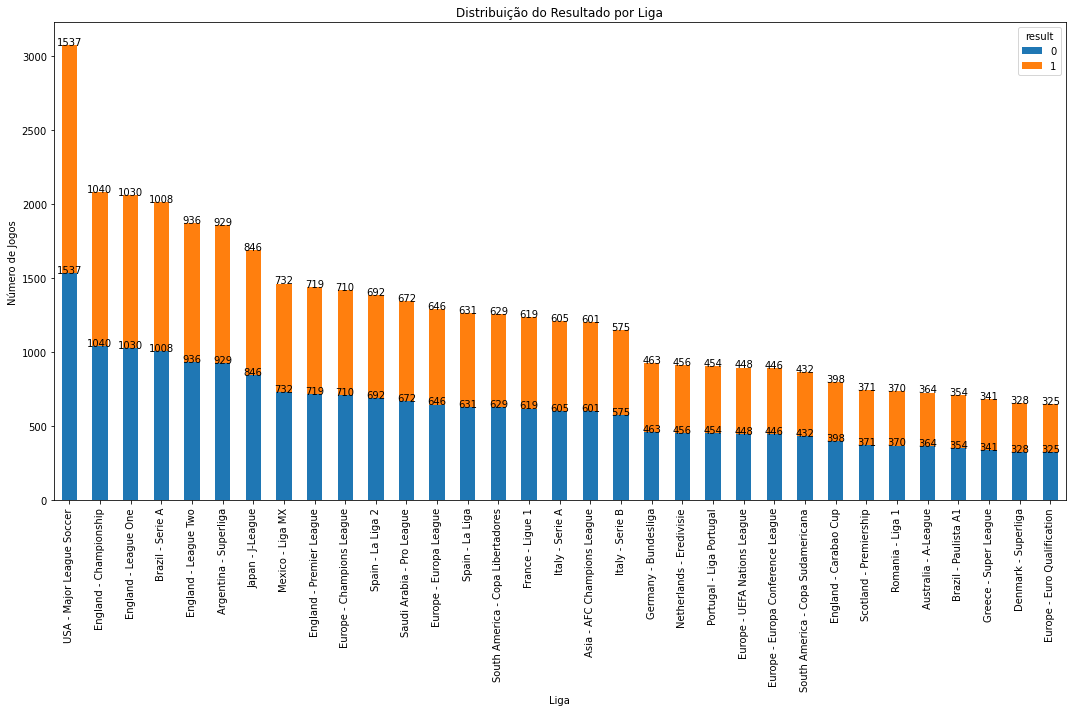

<Figure size 432x288 with 0 Axes>

In [27]:
# Função para filtrar ligas com base no número mínimo de partidas
def filter_leagues(df, league_col, matches, min_matches=100):
    # Agrupa o DataFrame por liga e conta o número único de partidas para cada liga
    league_game_counts = df.groupby(league_col)[matches].nunique()
    # Filtra para manter apenas as ligas com um número de partidas igual ou maior que min_matches
    leagues_filtered = league_game_counts[league_game_counts >= min_matches].index
    # Filtra o DataFrame original para incluir apenas linhas das ligas selecionadas
    filtered_data = df[df[league_col].isin(leagues_filtered)]
    return filtered_data

# Função para equilibrar o conjunto de dados com base na contagem de resultados em cada liga
# def balance_data(df, league_col='league', result_col='result'):
#     df = df.drop_duplicates()

#     leagues = df[league_col].unique()
#     # Lista para armazenar os DataFrames balanceados para cada liga
#     balanced_dfs = []

#     # Itera sobre cada liga para balancear os dados
#     for league in leagues:
#         # Filtra o DataFrame para incluir apenas dados da liga atual
#         league_df = df[df[league_col] == league]

#         # Conta o número de ocorrências de cada resultado na liga
#         result_counts = league_df[result_col].value_counts()
#         # Obtém o menor número de ocorrências entre os resultados
#         min_count = result_counts.min()

#         # Itera sobre os resultados únicos para balancear a quantidade de cada um
#         for result in league_df[result_col].unique():
#             # Define o tamanho da amostra com base no menor número de ocorrências
#             sample_size = min(min_count, result_counts[result])
#             # Coleta uma amostra aleatória de dados para o resultado atual
#             sampled_df = league_df[league_df[result_col] == result].sample(sample_size, random_state=42)
#             # Adiciona a amostra balanceada à lista
#             balanced_dfs.append(sampled_df)

#     # Combina todos os DataFrames balanceados em um único DataFrame
#     balanced_data = pd.concat(balanced_dfs).reset_index(drop=True)

#     return balanced_data

def balance_data(df, league_col='league', result_col='result'):
    leagues = df[league_col].unique()
    # Lista para armazenar os DataFrames balanceados para cada liga
    balanced_dfs = []

    # Itera sobre cada liga para balancear os dados
    for league in leagues:
        # Filtra o DataFrame para incluir apenas dados da liga atual
        league_df = df[df[league_col] == league]
        # Selecionando os registros onde 'result' é 1
        result_1 = league_df[league_df[result_col] == 1]

        # Contando os minutos únicos e suas ocorrências em 'result' 1
        minutes_counts = result_1['minute'].value_counts()

        # Selecionando registros onde 'result' é 0
        result_0_sample = pd.DataFrame()
        for minute, count in minutes_counts.items():
            sample = league_df[(league_df['result'] == 0) & (league_df['minute'] == minute)].sample(n=count, replace=False, random_state=42)
            result_0_sample = pd.concat([result_0_sample, sample])

        # Combinando os dois conjuntos de dados para formar um novo dataframe balanceado
        balanced_dfs.append(pd.concat([result_1, result_0_sample]))
    
    # Combina todos os DataFrames balanceados em um único DataFrame
    balanced_data = pd.concat(balanced_dfs).reset_index(drop=True)
    return balanced_data

# def balance_data_stratified(df, league_col='league', result_col='result'):
#     df = df.drop_duplicates()

#     leagues = df[league_col].unique()
#     balanced_dfs = []

#     for league in leagues:
#         league_df = df[df[league_col] == league]

#         # Conta o número total de ocorrências na liga
#         total_count = len(league_df)
#         result_counts = league_df[result_col].value_counts()

#         for result in league_df[result_col].unique():
#             # Calcula a proporção do resultado na liga
#             result_proportion = result_counts[result] / total_count
#             # Define o tamanho da amostra com base na proporção
#             sample_size = int(result_proportion * total_count)
#             sampled_df = league_df[league_df[result_col] == result].sample(sample_size, random_state=42)
#             balanced_dfs.append(sampled_df)

#     balanced_data = pd.concat(balanced_dfs).reset_index(drop=True)
#     return balanced_data


# from imblearn.over_sampling import SMOTE

# # Função para equilibrar o conjunto de dados com SMOTE
# def balance_data_with_smote(df, league_col='league', result_col='result', features_cols=[]):
#     df = df.drop_duplicates()

#     leagues = df[league_col].unique()
#     balanced_dfs = []

#     # Cria uma instância do SMOTE
#     smote = SMOTE(random_state=42)

#     for league in leagues:
#         league_df = df[df[league_col] == league]

#         # Separa as features e o target
#         X = league_df[features_cols]  
#         y = league_df[result_col]

#         # Aplica o SMOTE
#         X_resampled, y_resampled = smote.fit_resample(X, y)

#         # Combina os recursos e o target resampled de volta em um DataFrame
#         resampled_df = pd.DataFrame(X_resampled, columns=features_cols)
#         resampled_df[result_col] = y_resampled

#         balanced_dfs.append(resampled_df)

#     balanced_data = pd.concat(balanced_dfs).reset_index(drop=True)
#     return balanced_data




print("Contando partidas por time...")
total_matches_per_team = len(df['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

print("\nFiltrando dados de ligas...")
filtered_data = filter_leagues(df, 'league', 'match_id')
print("Dados filtrados:\n")
print(filtered_data['league'].value_counts())

print("\nBalanceando dados...")
# balanced_data = balance_data(filtered_data)
# leagues = filtered_data['league']
# matchs_ids = filtered_data['match_id']
# balanced_data = balance_data_with_smote(filtered_data, features_cols=df.drop(columns=['league', 'match_id', 'result', 'homeTeam', 'awayTeam']).columns)
# balanced_data['league'] = leagues
# balanced_data['match_id'] = matchs_ids

balanced_data = balance_data(filtered_data)

print("Dados balanceados:\n")
print(balanced_data['result'].value_counts())

# balanced_data = filtered_data.copy()

league_distribution = balanced_data.groupby(['league', 'result']).size().unstack()
sorted_leagues = league_distribution.sum(axis=1).sort_values(ascending=False).head(100).index

print("Contando partidas depois dos filtros...")
total_matches_per_team = len(balanced_data['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

plt.figure(figsize=(15, 10))
ax = league_distribution.loc[sorted_leagues].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribuição do Resultado por Liga')
plt.ylabel('Número de Jogos')
plt.xlabel('Liga')
plt.tight_layout()
plt.xticks(rotation=90)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0f}', (x + width/2, y + height), ha='center')

plt.show()
plt.clf()  

In [28]:
# Ordenando o DataFrame
df.sort_values(by=['match_id', 'minute'], inplace=True)

In [29]:
balanced_data.reset_index(drop=True, inplace=True)

In [30]:
balanced_data.value_counts('result')

result
0    20707
1    20707
Name: count, dtype: int64

In [33]:
balanced_data.to_csv("data_live_engineer.csv", index=False, encoding="utf-8")

In [32]:
balanced_data

,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,blockedShotsHome,blockedShotsAway,league,...,25_home,05ht_away,15ht_away,25ht_away,05ft_away,15ft_away,25ft_away,05_away,15_away,25_away
0,45,Carabobo FC,Club Universitario de Deportes,0.0,0.0,4.0,11.0,2.0,3.0,South America - Copa Libertadores,...,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0,1.000000,0.000000,0.0
1,82,Carabobo FC,Club Universitario de Deportes,1.0,0.0,8.0,20.0,2.0,4.0,South America - Copa Libertadores,...,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0,1.000000,0.000000,0.0
2,16,Club Guaraní,CD San José,0.0,0.0,7.0,0.0,1.0,0.0,South America - Copa Libertadores,...,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,23,Club Guaraní,CD San José,1.0,0.0,13.0,0.0,2.0,0.0,South America - Copa Libertadores,...,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4,76,Club Guaraní,CD San José,2.0,0.0,24.0,9.0,3.0,3.0,South America - Copa Libertadores,...,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41409,78,Romania,Kosovo,0.0,0.0,13.0,4.0,2.0,0.0,Europe - Euro Qualification,...,0.125000,0.125000,0.0,0.0,0.375000,0.000000,0.0,0.375000,0.000000,0.0
41410,75,Romania,Kosovo,0.0,0.0,13.0,4.0,2.0,0.0,Europe - Euro Qualification,...,0.125000,0.125000,0.0,0.0,0.375000,0.000000,0.0,0.375000,0.000000,0.0
41411,62,Romania,Kosovo,0.0,0.0,9.0,3.0,1.0,0.0,Europe - Euro Qualification,...,0.125000,0.125000,0.0,0.0,0.375000,0.000000,0.0,0.375000,0.000000,0.0
41412,43,Romania,Kosovo,0.0,0.0,4.0,3.0,1.0,0.0,Europe - Euro Qualification,...,0.125000,0.125000,0.0,0.0,0.375000,0.000000,0.0,0.375000,0.000000,0.0
